## Timelapse Segmentation

The goal of this notebook is twofold:
1. Exemplify how to access SNT without having to specify a local Fiji install
2. Exemplify how to analyze a time-lapse image previously skeletonized. For details, see this [forum discussion](https://forum.image.sc/t/filament-analysis-timelapse/59567/6?u=tferr)


<div class="alert alert-block alert-warning">
<b>Warning:</b> Until <a href="https://github.com/morphonets/SNT/issues/108">this issue</a> is solved, it won't be possible to initialize the latest version of SNT using the <tt>imagej.init(['sc.fiji:fiji', 'org.morphonets:SNT']</tt> strategy.
    In the interim, please use version 4.0.3 (as specified below), or use the ijfinder.py strategy as in previous notebooks.
</div>

In [1]:
import imagej
from scyjava import jimport
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.spatial.distance import directed_hausdorff

In [ ]:
ij = imagej.init(['sc.fiji:fiji', 'org.morphonets:SNT:4.0.3'], mode='interactive')

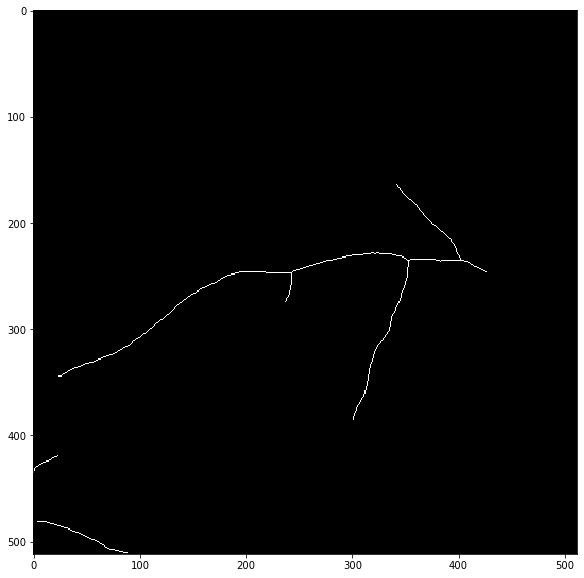

In [10]:
# Replace with your skeleton image
impath = "../images/skeleton_timeseries.tif" # relative path to demo image
dataset = ij.io().open(impath)

# Let's find out the time dimension index and the total number of frames
Axes = jimport("net.imagej.axis.Axes")
frame_dim_idx = dataset.dimensionIndex(Axes.TIME)
n_frames = dataset.dimension(frame_dim_idx)

# Plot the last frame since it contains the fully developed structures.
# From this, we gather that we should be able to segment the developmental stages
# of three distinct objects.
last_frame = ij.op().transform().hyperSliceView(dataset, frame_dim_idx, n_frames-1)

figure(figsize=(10,10))
ij.py.show(last_frame, cmap="gray")

The general approach is to obtain reconstructions of the connected components in the skeleton image at each frame, and to associate each reconstruction with it's closest matching "child" in the next frame, if one exists. 

In this instance, it is natural to represent the reconstructions as graph-theory objects, namely [trees](https://en.wikipedia.org/wiki/Tree_(graph_theory). We can use the [SkeletonConverter](https://javadoc.scijava.org/SNT/sc/fiji/snt/analysis/SkeletonConverter.html) class to generate these kinds of graph objects from a pre-skeletonized (or otherwise binary) image. Each graph will represent a single connected component in the skeleton image at frame t, with the vertex set given by the connected voxels defining the component and edges linking adjacent voxels. The concrete graph data type is [DirectedWeightedGraph](https://javadoc.scijava.org/SNT/sc/fiji/snt/analysis/graph/DirectedWeightedGraph.html), which encapsulates various methods for manipulation and analysis of the resulting tree structure.

To construct a "lineage" of graph objects, we can store two pointers along with a graph. One for the parent object in the previous frame, and one for the child object in the next frame. The term "lineage" is used rather loosely here, as we assume an object may have at most one child in the next frame.

In [4]:
# Import a couple helpful Java classes
ImageJFunctions = jimport("net.imglib2.img.display.imagej.ImageJFunctions")
SkeletonConverter = jimport("sc.fiji.snt.analysis.SkeletonConverter")

class LineageNode:
    """Minimal class representing a node in a doubly linked list. We can use this to wrap 
    a graph object with its matched "child" in the next frame and the matched "parent" 
    in the previous frame, along with the index of the frame the graph exists in."""
    
    def __init__(self, graph, parent, child, frame):
        self.graph = graph
        self.parent = parent
        self.child = child
        self.frame = frame
        

# Extract graph objects from the skeletonized image at each frame
lineage_nodes_by_frame = {}
for frame_idx in range(n_frames):
    # Extract the image slice at the current frame
    frame_img = ij.op().transform().hyperSliceView(dataset, frame_dim_idx, frame_idx)
    # Convert to ImagePlus since that is the data type expected by
    # AnalyzeSkeleton_ (and thus SkeletonConverter).
    frame_imp = ImageJFunctions.wrap(frame_img, "")
    # Since the wrapped ImagePlus is a virtual stack, it must be duplicated
    # if we want to write to the pixel data. 
    # Otherwise,the routine will hang forever...
    skeletonize = False  # The input is already a skeleton.
    converter = SkeletonConverter(frame_imp.duplicate(), skeletonize)
    # Obtain the reconstructions at the current frame.
    # These structures are represented as directed graphs -- 
    # specifically, rooted trees. There will be one graph
    # for each connected component in the skeleton image at 
    # the current frame.
    graphs = converter.getGraphs()
    # Prune components with fewer than 5 connected voxels
    graphs = filter(lambda x: x.vertexSet().size() >= 5, graphs)
    # Construct a LineageNode instance from each graph object, leaving
    # the parent and child fields empty for now. We will fill those
    # later when matching objects across frames.
    lineage_nodes = []
    for g in graphs:
        lineage_nodes.append(LineageNode(g, None, None, frame_idx))
    # Store all the nodes at the current frame in a dictionary.
    # We'll use this when matching graphs between frames
    lineage_nodes_by_frame[frame_idx] = lineage_nodes

We will naively match trees between frames brute-force by computing the [Hausdorff distance](https://en.wikipedia.org/wiki/Hausdorff_distance) between the point sets of a query graph and all the graphs in the next frame. If the amount of growth between frames is small enough and a single object does not split into two or merge with another, this should work reasonably well.

In [5]:
def graph_to_points(graph):
    """Decompose a graph into an m x 3 array of x,y,z coordinates.
    If the graph originates from a 2D image, all z coordinates are 0"""
    points = []
    for v in graph.vertexSet():
        points.append([v.getX(), v.getY(), v.getZ()])
    return np.array(points)


def find_match(query_node, target_nodes, max_distance):
    """Match a query LineageNode against a set of target LineageNodes by finding
    the target with minimum hausdorff distance to the query.
    If the best matching target is beyond the maximum distance cutoff,
    return no match."""
    query_points = graph_to_points(query_node.graph)
    min_dx = float("inf")
    best_match = None
    for target in target_nodes:
        target_points = graph_to_points(target.graph)
        dx = max(
            directed_hausdorff(query_points, target_points)[0], 
            directed_hausdorff(target_points, query_points)[0]
        )
        if dx < min_dx:
            min_dx = dx
            best_match = target
    if min_dx > max_distance:
        return None
    return best_match


# Brute-force matching of connected components across frames.
# If the best candidate is more than max_distance
# away from the query, it is rejected.
max_distance = 50
for frame, nodes in sorted(lineage_nodes_by_frame.items()):
    if frame + 1 >= n_frames:
        # components in the last frame will have no children
        continue
    lineage_nodes_at_next_frame = lineage_nodes_by_frame[frame + 1]
    # For each node in the current frame,
    # find the best match (if one exists) in the next frame.
    for n in nodes:
        match = find_match(n, lineage_nodes_at_next_frame, max_distance)
        if match is not None:
            # Assign relationships in both directions
            n.child = match
            match.parent = n

Now we'll define some helper functions to interact with our lineages. We'll have one function that obtains the root nodes (i.e., the set of nodes with no parent) from the set of all nodes, and another that gets all the descendants of a given node. Note that the descendent list is always flat, since each node can have only one child. Finally, we'll have one method that converts a list of our custom LineageNode objects to a list of standard SNT [Tree](https://javadoc.scijava.org/SNT/sc/fiji/snt/Tree.html) objects, as the latter can be passed to SNT's various visualization and analysis routines.

In [6]:
def get_roots(lineage_nodes_by_frame):
    """Get the list of root nodes (i.e., the set of 
    nodes with no parent) from the dictionary of LineageNode objects"""
    roots = []
    for nodes in lineage_nodes_by_frame.values():
        roots.extend(filter(lambda n: n.parent is None, nodes))
    return roots


def get_descendants(lineage_node):
    """Get a list of descendants given a LineageNode.
    The descendant list includes the given node too."""
    lineage = []
    while lineage_node is not None:
        lineage.append(lineage_node)
        lineage_node = lineage_node.child
    return lineage


def lineage_to_trees(lineage_nodes):
    """Convert a list of LineageNode objects
    to a list of Tree objects"""
    lineage_trees = []
    for node in lineage_nodes:
        # Convert the low-level graph to a high-level
        # Tree object, which we can pass to
        # various analysis and visualization
        # routines.
        # See DirectedWeightedGraph#getTree()
        tree = node.graph.getTree()
        lineage_trees.append(tree)
    return lineage_trees

The number of roots will give the number of lineages

In [7]:
roots = get_roots(lineage_nodes_by_frame)
print(len(roots), "objects detected")

lineages = [lineage_to_trees(get_descendants(r)) for r in roots]

3 objects detected


Let's plot the evolution of the largest component and color code by total length at each frame. Since the input image is uncalibrated, length is measured in pixels. For this, we can use the [MultiTreeColorMapper](https://javadoc.scijava.org/SNT/sc/fiji/snt/analysis/MultiTreeColorMapper.html) and [ColorTables](https://javadoc.scijava.org/ImageJ/net/imagej/display/ColorTables.html) classes.

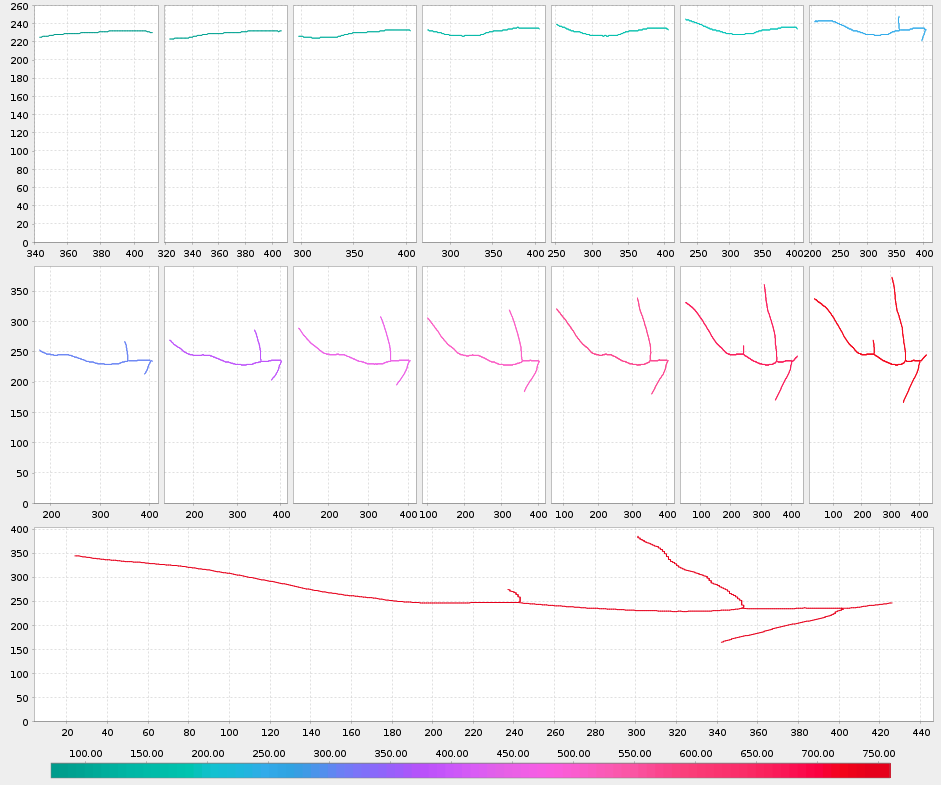

In [8]:
ColorTables = jimport("net.imagej.display.ColorTables")
MultiTreeColorMapper = jimport("sc.fiji.snt.analysis.MultiTreeColorMapper")

def get_multiviewer(lineage_trees, metric):
    mapper = MultiTreeColorMapper(lineage_trees)
    mapper.map(metric, ColorTables.ICE)
    minmax = mapper.getMinMax()
    v = mapper.getMultiViewer()
    v.setColorBarLegend(ColorTables.ICE, minmax[0], minmax[1])
    return v

# The first lineage also happens to be the most interesting in this case
viewer = get_multiviewer(lineages[0], MultiTreeColorMapper.LENGTH)
viewer.show()

We can also measure [Trees](https://javadoc.scijava.org/SNT/sc/fiji/snt/Tree.html) with [TreeStatistics](https://javadoc.scijava.org/SNT/sc/fiji/snt/analysis/TreeStatistics.html) and [MultiTreeStatistics](https://javadoc.scijava.org/SNT/sc/fiji/snt/analysis/MultiTreeStatistics.html) classes, and plot measurements as a function of time.

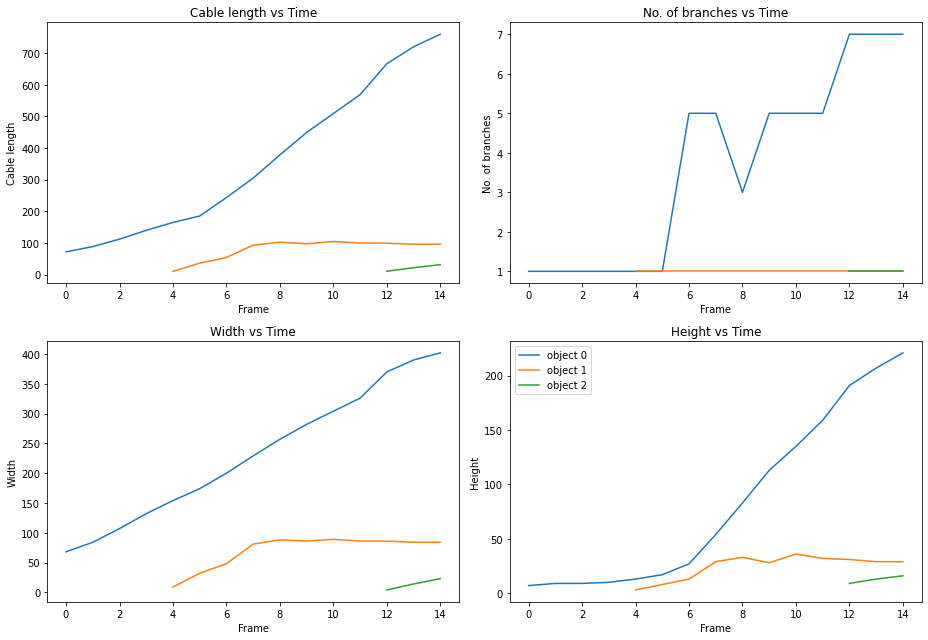

In [9]:
TreeStatistics = jimport("sc.fiji.snt.analysis.TreeStatistics")
MultiTreeStatistics = jimport("sc.fiji.snt.analysis.MultiTreeStatistics")

def plot_metric(root_nodes, metric, ax):
    # Plot the measurements for each lineage
    for i, r in enumerate(roots):
        lineage_trees = lineage_to_trees(get_descendants(r))
        xs = np.arange(r.frame, r.frame + len(lineage_trees))
        ys = [TreeStatistics(tree).getMetric(metric) for tree in lineage_trees]
        ax.set_title(f"{metric} vs Time")
        ax.set_ylabel(f"{metric}")
        ax.set_xlabel("Frame")
        ax.plot(xs, ys, label=f"object {i}")


fig, ax = plt.subplots(2, 2, figsize=(13,9))
plot_metric(roots, MultiTreeStatistics.LENGTH, ax[0][0])
plot_metric(roots, MultiTreeStatistics.N_BRANCHES, ax[0][1])    
plot_metric(roots, MultiTreeStatistics.WIDTH, ax[1][0])
plot_metric(roots, MultiTreeStatistics.HEIGHT, ax[1][1])
fig.tight_layout()
plt.legend(loc="upper left")
plt.show()

Exercise for the reader: how might one prune the graphs of spurious micro-branches that interfere with analysis? 
See [here](https://jgrapht.org/javadoc/org.jgrapht.core/org/jgrapht/Graph.html) for hints